# Set connection with GitHub

In [1]:
# ! cd /kaggle/working && rm -rf RECsys_Challenge2024

In [2]:
from kaggle_secrets import UserSecretsClient

token = UserSecretsClient().get_secret("Token")

! git clone https://{token}@github.com/madratak/RECsys_Challenge2024.git

Cloning into 'RECsys_Challenge2024'...
remote: Enumerating objects: 5651, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 5651 (delta 141), reused 52 (delta 15), pack-reused 5314 (from 2)
Receiving objects: 100% (5651/5651), 386.19 MiB | 39.05 MiB/s, done.
Resolving deltas: 100% (3187/3187), done.
Updating files: 100% (461/461), done.


In [3]:
! pip install PyGithub requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 34.5 MB/s eta 0:00:00


In [4]:
! pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 65.6 MB/s eta 0:00:00


In [5]:
%cd /kaggle/working/RECsys_Challenge2024
! python run_compile_all_cython.py

/kaggle/working/RECsys_Challenge2024
run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/usr/bin/python3'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1252:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disabl

In [6]:
from Utils.notebookFunctions import *
from Utils.xgboost_functions import *
import numpy as np
import pandas as pd
import scipy.sparse as sps
import time
import shutil
import optuna
import json
import os
import gc
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
from tqdm import tqdm
from xgboost import XGBRanker

import warnings
import gc
from scipy.stats import skew, kurtosis
from numpy import linalg as LA

%matplotlib inline
from xgboost import plot_importance

K_PATH = '/kaggle/working/RECsys_Challenge2024'
GH_PATH = 'TrainedModels/WithoutKFCV'
D_PATH = 'XGBoost'

np.random.seed(42)

In [7]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.MatrixFactorization.FasterIALSRecommender import FasterIALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import ScaledPureSVDRecommender
from Recommenders.Neural.MultVAE_PyTorch_Recommender import MultVAERecommender_PyTorch_OptimizerMask 
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python

## Import the repository

In [8]:
repo = get_repo_from_github(token)

Repository 'RECsys_Challenge2024' found.


In [9]:
config = {
    'model': 'XGBoostNoContNoCatHybrid',
    'metric': 'MAP',
    'categorical': False,
    'contents': False,
    'tune_parameters': True,
    'database_path': '/kaggle/working/history_XGBoostNoContNoCatHybrid_MAP.db',
    'copy_prev_best_params': False,
    'tune_best_params': True,
    'save_github': True
}

Import the database where previous tuning trials have been saved.

In [10]:
try:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Construction of URM and ICM matrices

In [11]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")

n_users = len(URM_all_dataframe["user_id"].unique())
n_items = len(URM_all_dataframe["item_id"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)),
                        shape = (n_users, n_items))

URM_all

<35736x38121 sparse matrix of type '<class 'numpy.float64'>'
	with 1764607 stored elements in Compressed Sparse Row format>

In [12]:
ICM_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")

n_items = len(ICM_dataframe["item_id"].unique())
n_features = len(ICM_dataframe["feature_id"].unique())

ICM_all = sps.csr_matrix((ICM_dataframe["data"].values, 
                          (ICM_dataframe["item_id"].values, ICM_dataframe["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all

<38121x94331 sparse matrix of type '<class 'numpy.float64'>'
	with 2940040 stored elements in Compressed Sparse Row format>

## Import dataframes

In [13]:
model_referred = config["model"].replace("NoCat", "")
dataframes_path = f'/kaggle/input/dataframes-{model_referred.lower()}'

if os.path.exists(dataframes_path):
    print("Dataframe directory is ready to be used.")
else:
    print("No dataframes directory is present.")

Dataframe directory is ready to be used.


# Training
Split the dataset in train, validation and test set.

In [14]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


Function to fit the hybrid recommender that is going to be used as candidate generator.

In [15]:
def fit_hybrid_recommender(URM_train, recommenders_hybrid_recommenders):
    # Load best parameters
    param_file_path = os.path.join(
        GH_PATH, "Hybrid/LinearCombination", 
        f"SecondLinearCombinationRecommender", f"OptimizingRecall", 
        f"best_params_SecondLinearCombination_Recall.json"
    )
    
    try:
        with open(param_file_path, 'r') as best_params_json:
            best_params = json.load(best_params_json)
    except FileNotFoundError:
        print(f"Error: Parameter file not found.")

    # Extract the weights and normalize them
    weights = list(best_params.values())[1:]  # Extract weight values (excluding 'norm')
    total_weight = sum(weights)
    normalized_weights = [weight / total_weight for weight in weights]  # Normalize weights

    fit_params = {
        "weights": normalized_weights,  # Use normalized weights
        "norm": best_params["norm"]     # Pass 'norm' as is
    }
    
    hybrid_cg = LinearCombinationRecommender(URM_train, recommenders_hybrid_recommenders.values())
    hybrid_cg.fit(**fit_params)
    print("Training completed.\n")
    
    cg_recommenders = {
        "SecondLinearCombination": hybrid_cg
    }
    
    return cg_recommenders

## Candidate Generators

Select the best previously trained recommenders to use inside the hybrid recommender (candidate generator).

In [16]:
h_recommenders = {
    "ItemKNNCF": ItemKNNCFRecommender,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "RP3beta": RP3betaRecommender,
}

## Features
Select the other previously trained recommenders to use them as features.

In [17]:
f_recommenders = {
    "RP3beta": RP3betaRecommender,
    "P3alpha": P3alphaRecommender,
    "ItemKNNCF": ItemKNNCFRecommender,
    "ItemKNNCBF": ItemKNNCBFRecommender,
    "UserKNNCF": UserKNNCFRecommender,
    "FasterIALS": FasterIALSRecommender,
    "NMF": NMFRecommender,
    "PureSVDItem": PureSVDItemRecommender,
    "ScaledPureSVD": ScaledPureSVDRecommender,
    "MultVAE": MultVAERecommender_PyTorch_OptimizerMask,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "SLIM_BPR": SLIM_BPR_Python,
}

## Training dataframe building
Build the dataframe with the predictions, the popularity of the item, the user activity, the profile length, item features and others.

Then, set features and target to use for the training.

In [18]:
if config["tune_parameters"]:
    
    if os.path.exists(dataframes_path + f'/training_dataframe_{model_referred}.parquet'):
        training_dataframe = pd.read_parquet(dataframes_path + f'/training_dataframe_{model_referred}.parquet')
        groups_train = training_dataframe.groupby("UserID").size().values
    
    else:
        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        hybrid_recommenders = fit_recommenders("Recall", "Train", URM_train, ICM_all, h_recommenders, GH_PATH, "cg", repo)
        candidate_generator_recommenders = fit_hybrid_recommender(URM_train, hybrid_recommenders)
    
        del hybrid_recommenders

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "Train", URM_train, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        training_dataframe, groups_train = create_XGBoost_dataframe(URM_train, candidate_generator_recommenders, features_recommenders, ICM_all, URM_validation, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        training_dataframe.to_parquet(f'/kaggle/working/training_dataframe_{model_referred}.parquet')

        del candidate_generator_recommenders, features_recommenders

    training_dataframe["UserID"] = training_dataframe["UserID"].astype("int")
    training_dataframe["ItemID"] = training_dataframe["ItemID"].astype("int")
    
    display(training_dataframe)

    y_train = training_dataframe["Label"]
    X_train = training_dataframe.drop(columns=["Label"])

    del training_dataframe

,UserID,ItemID,Label,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,399,False,7,0.643288,6.0,0.469522,19.0,0.514353,6.0,...,1.0,13.666667,14.913894,1.0,41.0,6.0,0.797779,-0.910574,0.146779,0.017751
1,0,6380,False,2,0.000000,46.0,0.000000,43.0,0.000000,39.0,...,13.0,26.916667,14.920750,2.0,46.0,28.5,-0.279063,-1.185053,0.192186,0.017751
2,0,6546,False,2,0.264123,30.0,0.369501,26.0,0.395685,12.0,...,17.0,25.416667,13.701084,8.0,49.0,24.5,0.397716,-0.902900,0.063358,0.017751
3,0,6822,True,1,0.214973,38.0,0.000000,42.0,0.000000,37.0,...,49.0,28.833333,13.085963,4.0,49.0,30.5,-0.428730,-0.639405,0.128828,0.017751
4,0,6915,False,1,0.000000,45.0,0.000000,41.0,0.000000,36.0,...,34.0,33.000000,10.804040,6.0,45.0,35.0,-1.204807,1.237750,0.119324,0.017751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36035,False,3,0.000000,42.0,0.000000,40.0,0.149139,38.0,...,9.0,23.416667,12.950664,6.0,42.0,23.5,0.108149,-1.460116,0.040127,0.006455
1786796,35735,36087,False,3,0.465253,10.0,0.514387,8.0,0.563263,11.0,...,22.0,18.916667,10.680980,3.0,40.0,20.0,0.442351,-0.501339,0.052798,0.006455
1786797,35735,36092,False,0,0.276075,19.0,0.130650,32.0,0.248852,26.0,...,20.0,23.750000,8.614206,15.0,45.0,19.5,1.307097,0.988657,0.020063,0.006455
1786798,35735,35051,False,0,0.121656,38.0,0.000000,43.0,0.215404,32.0,...,43.0,40.500000,3.825750,32.0,45.0,42.0,-0.930945,-0.039119,0.012672,0.006455


## Validation and Testing dataframe building

The first dataset excludes the label column since it is used to evaluate the performance of the model with the hyperparameters chosen by Optuna. In contrast, the second dataset includes the label column and is used to train the final model selected by Optuna.

In [19]:
if config["tune_parameters"] or config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/testing_dataframe_{model_referred}.parquet' ):
        testing_dataframe = pd.read_parquet(dataframes_path + f'/testing_dataframe_{model_referred}.parquet')
        groups_test = testing_dataframe.groupby("UserID").size().values
        print("testing_dataframe and groups_test loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        hybrid_recommenders = fit_recommenders("Recall", "TrainVal", URM_train + URM_validation, ICM_all, h_recommenders, GH_PATH, "cg", repo)
        candidate_generator_recommenders = fit_hybrid_recommender(URM_train + URM_validation, hybrid_recommenders)

        del hybrid_recommenders

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainVal", URM_train + URM_validation, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        testing_dataframe, groups_test = create_XGBoost_dataframe(URM_train + URM_validation, candidate_generator_recommenders, features_recommenders, ICM_all, URM_test, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        testing_dataframe.to_parquet(f'/kaggle/working/testing_dataframe_{model_referred}.parquet')

        del candidate_generator_recommenders, features_recommenders

    testing_dataframe["UserID"] = testing_dataframe["UserID"].astype("int")
    testing_dataframe["ItemID"] = testing_dataframe["ItemID"].astype("int")    

    if config["tune_parameters"]:
        validation_dataframe = testing_dataframe.drop(columns=["Label"])
        display(validation_dataframe)

testing_dataframe and groups_test loaded.


,UserID,ItemID,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,ItemKNNCBF_score,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,51,2,0.774121,6.0,0.788552,4.0,0.286975,25.0,0.000000,...,35.0,30.250000,17.040727,4.0,49.0,31.0,-0.299086,-1.427364,0.109336,0.020373
1,0,4232,1,0.221817,42.0,0.234536,38.0,0.000000,46.0,0.000000,...,8.0,32.333333,12.492422,8.0,46.0,36.0,-0.688627,-0.692253,0.133726,0.020373
2,0,4253,2,0.301324,37.0,0.378786,24.0,0.000000,47.0,0.000000,...,19.0,27.916667,15.512214,5.0,49.0,24.0,-0.007002,-1.295642,0.391085,0.020373
3,0,4534,0,0.495706,23.0,0.457571,20.0,0.000000,48.0,0.000000,...,31.0,34.333333,9.345231,20.0,49.0,35.0,0.049897,-0.991832,0.025231,0.020373
4,0,6348,4,0.492094,24.0,0.481187,18.0,0.440489,20.0,0.000000,...,10.0,20.333333,13.607039,4.0,50.0,20.0,0.688831,-0.083108,0.188394,0.020373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36092,0,0.226749,28.0,0.000000,46.0,0.132868,35.0,0.000000,...,28.0,32.500000,8.764598,11.0,46.0,33.5,-0.964209,1.280216,0.017662,0.005576
1786796,35735,36093,0,0.110596,40.0,0.103632,36.0,0.166914,32.0,0.139301,...,13.0,34.000000,9.015139,13.0,45.0,35.5,-0.933076,0.388766,0.038688,0.005576
1786797,35735,36321,2,0.000000,48.0,0.128940,30.0,0.201668,26.0,0.183126,...,40.0,29.000000,15.391851,5.0,48.0,32.0,-0.305597,-1.284461,0.114382,0.005576
1786798,35735,35292,1,0.412324,14.0,0.405672,15.0,0.294737,21.0,0.230943,...,6.0,21.833333,10.718152,6.0,46.0,21.5,0.935094,0.524080,0.035324,0.005576


## XGBoost training
Let's train XGBoost to rerank those prediction using as lable whether they should be recommended or not.

In [20]:
from Recommenders.XGBoost.XGBoostRankerRecommender import XGBoostRankerRecommender

def objective_function_XGBoostRanker(optuna_trial):
    
    recommender_instance = XGBoostRankerRecommender(URM_train + URM_validation, X_train, y_train, validation_dataframe)

    full_hyperp = {
            "n_estimators": optuna_trial.suggest_int("n_estimators", 50, 500),
            "learning_rate": optuna_trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "reg_alpha": optuna_trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
            "reg_lambda": optuna_trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
            "max_depth": optuna_trial.suggest_int("max_depth", 3, 12),
            "max_leaves": optuna_trial.suggest_int("max_leaves", 2, 256),
            "grow_policy": optuna_trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "booster": optuna_trial.suggest_categorical("booster", ["gbtree", "dart"]),
            # "tree_method": optuna_trial.suggest_categorical("tree_method", ["hist", "gpu_hist", "approx"]),
            "tree_method": "hist",
            "objective": optuna_trial.suggest_categorical("objective", ["map", "pairwise", "ndcg"])
        }

    recommender_instance.fit(
        groups_train,
        **full_hyperp
    )

    result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
    
    return result_df.loc[10]["MAP"]

In [21]:
if config['tune_parameters']:
    
    optuna_study = optuna.create_study(direction='maximize', study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)

    optuna_study.optimize(objective_function_XGBoostRanker, n_trials=5)

[I 2025-01-03 11:20:56,492] Using an existing study with name 'hyperparameters_tuning_XGBoostNoContNoCatHybrid_MAP' instead of creating a new one.


EvaluatorHoldout: Processed 27000 (75.9%) in 5.13 min. Users per second: 88
EvaluatorHoldout: Processed 35595 (100.0%) in 6.75 min. Users per second: 88


[I 2025-01-03 11:29:42,983] Trial 6 finished with value: 0.06158426923702792 and parameters: {'n_estimators': 237, 'learning_rate': 0.018787229661945595, 'reg_alpha': 0.11851204305078329, 'reg_lambda': 0.01622219545351445, 'max_depth': 10, 'max_leaves': 186, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 5 with value: 0.06207324798159032.


EvaluatorHoldout: Processed 24000 (67.4%) in 5.01 min. Users per second: 80
EvaluatorHoldout: Processed 35595 (100.0%) in 7.37 min. Users per second: 80


[I 2025-01-03 11:40:05,251] Trial 7 finished with value: 0.04554179180685539 and parameters: {'n_estimators': 473, 'learning_rate': 0.14620946604352447, 'reg_alpha': 0.20662857064954585, 'reg_lambda': 0.0001262739401658191, 'max_depth': 10, 'max_leaves': 224, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'objective': 'pairwise'}. Best is trial 5 with value: 0.06207324798159032.


EvaluatorHoldout: Processed 31000 (87.1%) in 5.11 min. Users per second: 101
EvaluatorHoldout: Processed 35595 (100.0%) in 5.87 min. Users per second: 101


[I 2025-01-03 11:47:18,115] Trial 8 finished with value: 0.05786409942541204 and parameters: {'n_estimators': 267, 'learning_rate': 0.0001737396287680764, 'reg_alpha': 0.00885122956392201, 'reg_lambda': 0.19000398481206954, 'max_depth': 3, 'max_leaves': 249, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'pairwise'}. Best is trial 5 with value: 0.06207324798159032.


EvaluatorHoldout: Processed 31000 (87.1%) in 5.15 min. Users per second: 100
EvaluatorHoldout: Processed 35595 (100.0%) in 5.89 min. Users per second: 101


[I 2025-01-03 11:53:57,054] Trial 9 finished with value: 0.06167592425367218 and parameters: {'n_estimators': 93, 'learning_rate': 0.02872585184094457, 'reg_alpha': 0.012488971345558606, 'reg_lambda': 0.000424500786830219, 'max_depth': 8, 'max_leaves': 80, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 5 with value: 0.06207324798159032.


EvaluatorHoldout: Processed 18000 (50.6%) in 5.15 min. Users per second: 58
EvaluatorHoldout: Processed 35595 (100.0%) in 10.21 min. Users per second: 58


[I 2025-01-03 14:22:16,866] Trial 10 finished with value: 0.061879912240213525 and parameters: {'n_estimators': 189, 'learning_rate': 0.03198363515900352, 'reg_alpha': 0.000302476343264931, 'reg_lambda': 0.004096532179105171, 'max_depth': 6, 'max_leaves': 151, 'grow_policy': 'depthwise', 'booster': 'dart', 'objective': 'map'}. Best is trial 5 with value: 0.06207324798159032.


### Some optuna visualizations on recommender parameters

In [22]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_slice(optuna_study)
fig.show()

In [23]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_param_importances(optuna_study)
fig.show()

# Testing
## Prediction dataframe building

In [24]:
if config["tune_best_params"]:
    display(testing_dataframe)

,UserID,ItemID,Label,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,51,False,2,0.774121,6.0,0.788552,4.0,0.286975,25.0,...,35.0,30.250000,17.040727,4.0,49.0,31.0,-0.299086,-1.427364,0.109336,0.020373
1,0,4232,False,1,0.221817,42.0,0.234536,38.0,0.000000,46.0,...,8.0,32.333333,12.492422,8.0,46.0,36.0,-0.688627,-0.692253,0.133726,0.020373
2,0,4253,False,2,0.301324,37.0,0.378786,24.0,0.000000,47.0,...,19.0,27.916667,15.512214,5.0,49.0,24.0,-0.007002,-1.295642,0.391085,0.020373
3,0,4534,False,0,0.495706,23.0,0.457571,20.0,0.000000,48.0,...,31.0,34.333333,9.345231,20.0,49.0,35.0,0.049897,-0.991832,0.025231,0.020373
4,0,6348,False,4,0.492094,24.0,0.481187,18.0,0.440489,20.0,...,10.0,20.333333,13.607039,4.0,50.0,20.0,0.688831,-0.083108,0.188394,0.020373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36092,False,0,0.226749,28.0,0.000000,46.0,0.132868,35.0,...,28.0,32.500000,8.764598,11.0,46.0,33.5,-0.964209,1.280216,0.017662,0.005576
1786796,35735,36093,False,0,0.110596,40.0,0.103632,36.0,0.166914,32.0,...,13.0,34.000000,9.015139,13.0,45.0,35.5,-0.933076,0.388766,0.038688,0.005576
1786797,35735,36321,False,2,0.000000,48.0,0.128940,30.0,0.201668,26.0,...,40.0,29.000000,15.391851,5.0,48.0,32.0,-0.305597,-1.284461,0.114382,0.005576
1786798,35735,35292,False,1,0.412324,14.0,0.405672,15.0,0.294737,21.0,...,6.0,21.833333,10.718152,6.0,46.0,21.5,0.935094,0.524080,0.035324,0.005576


In [25]:
if config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/prediction_dataframe_{model_referred}.parquet'):
        prediction_dataframe = pd.read_parquet(dataframes_path + f'/prediction_dataframe_{model_referred}.parquet')
        print("prediction_dataframe loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        hybrid_recommenders = fit_recommenders("Recall", "TrainValTest", URM_all, ICM_all, h_recommenders, GH_PATH, "cg", repo)
        candidate_generator_recommenders = fit_hybrid_recommender(URM_train, hybrid_recommenders)
    
        del hybrid_recommenders

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainValTest", URM_all, ICM_all, f_recommenders, GH_PATH, "f", repo)

        print()
        prediction_dataframe = create_XGBoost_dataframe(URM_all, candidate_generator_recommenders, features_recommenders, ICM_all, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        prediction_dataframe.to_parquet("/kaggle/working/prediction_dataframe_hybrid.parquet")

        del candidate_generator_recommenders, features_recommenders

    prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype("int")
    prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype("int")
    
    display(prediction_dataframe)

    y_test = testing_dataframe["Label"]
    X_test = testing_dataframe.drop(columns=["Label"])

    del testing_dataframe

prediction_dataframe loaded.


,UserID,ItemID,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,ItemKNNCBF_score,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,120,2,0.207579,42.0,0.209291,34.0,0.156088,39.0,0.000000,...,18.0,25.583333,12.456895,5.0,42.0,26.5,-0.374625,-0.869184,0.087755,0.019338
1,0,7702,5,0.491866,11.0,0.573662,3.0,0.715664,3.0,0.000000,...,5.0,23.833333,19.807406,3.0,49.0,16.5,0.257932,-1.710551,0.076190,0.019338
2,0,7703,3,0.550575,8.0,0.469894,12.0,0.571797,10.0,0.999996,...,25.0,26.916667,18.228142,1.0,50.0,24.0,0.151079,-1.488256,0.053741,0.019338
3,0,8505,1,0.443596,13.0,0.573209,4.0,0.257220,31.0,0.000000,...,37.0,27.000000,12.735063,4.0,46.0,29.0,-0.274456,-0.906699,0.112925,0.019338
4,0,9448,2,0.200648,43.0,0.124375,40.0,0.138147,41.0,0.216835,...,48.0,28.833333,13.016307,9.0,48.0,26.0,-0.097398,-1.217574,0.022449,0.019338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36773,8,0.600073,10.0,0.448528,14.0,0.444607,19.0,0.129655,...,2.0,11.000000,7.885545,2.0,30.0,9.5,1.123529,0.831948,0.036735,0.006277
1786796,35735,36775,3,0.433120,16.0,0.432025,15.0,0.488240,15.0,0.139301,...,37.0,14.916667,9.967751,1.0,37.0,14.5,0.844115,0.388567,0.059864,0.006277
1786797,35735,36776,9,0.805106,3.0,0.648569,4.0,0.600504,9.0,0.461886,...,3.0,8.500000,8.129632,2.0,29.0,5.5,1.552320,1.425447,0.017687,0.006277
1786798,35735,36087,1,0.339111,19.0,0.333030,19.0,0.331644,27.0,0.139301,...,31.0,26.083333,11.657681,4.0,46.0,25.0,-0.033846,-0.445817,0.058503,0.006277


### Train best XGBoost model

In [26]:
if config['tune_best_params']:

    if config['tune_parameters']:
        best_params = optuna_study.best_trial.params
    else: 
        with open(f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 'r') as best_params_json:
            best_params = json.load(best_params_json)

    recommender_instance = XGBoostRankerRecommender(URM_all, X_test, y_test, prediction_dataframe)
    recommender_instance.fit(
        groups_test,
        **best_params
    )

## Feature importance

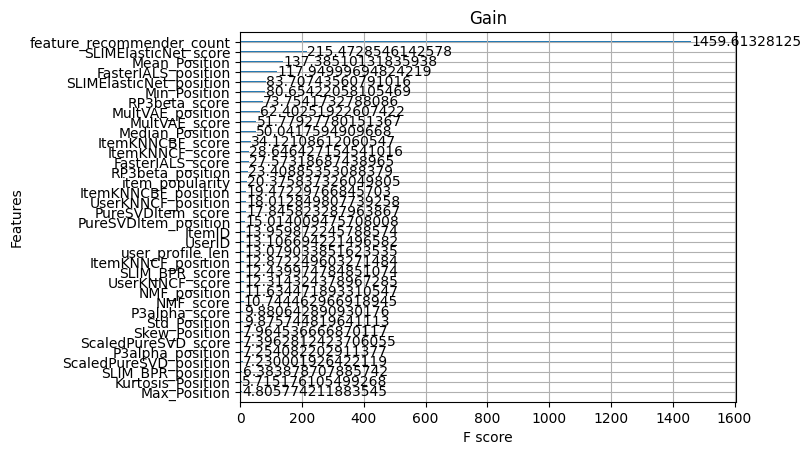

In [27]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='gain', title='Gain')

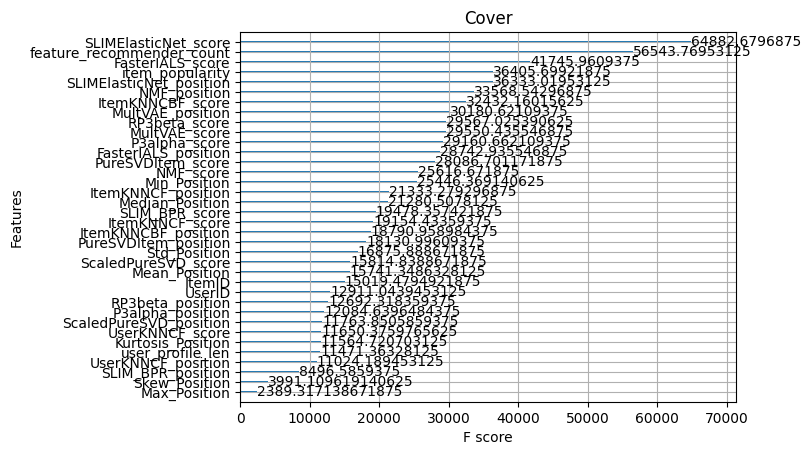

In [28]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='cover', title='Cover')

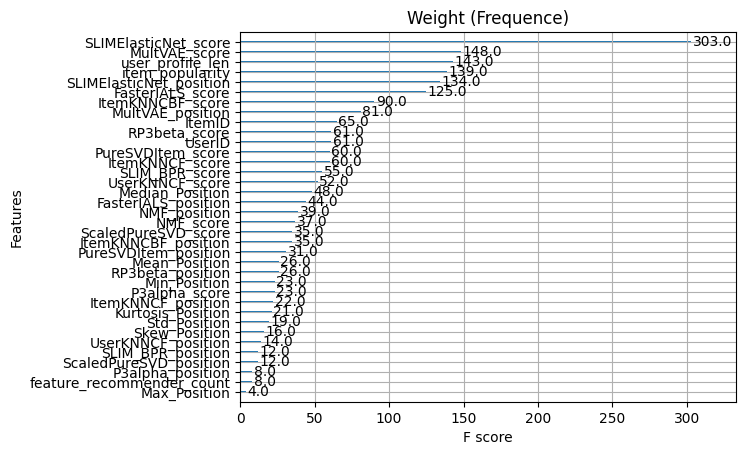

In [29]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='weight', title='Weight (Frequence)')

# Submission

Create the recommendations for the submission.

In [30]:
if config['tune_best_params']:

    data_target_users_test = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv')
    create_submission(data_target_users_test, recommender_instance, f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv')

Submission file saved as /kaggle/working/submission_XGBoostNoContNoCatHybrid_MAP.csv


# Save Version on GitHub 

Write or import a json file where best hyperparameters are saved. 

In [31]:
if config['tune_parameters']:
    with open(f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 'w') as params_file:
        json.dump(optuna_study.best_params, params_file)
        
    if config['save_github']:
        upload_file(
            f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{config["model"]}_{config["metric"]} tuning results (from kaggle notebook)',
            repo
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/'\
        f'best_params_{config["model"]}_{config["metric"]}.json', 
        f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json'
    )

File 'TrainedModels/WithoutKFCV/XGBoost/XGBoostNoContNoCatHybridRecommender/OptimizingMAP/best_params_XGBoostNoContNoCatHybrid_MAP.json' created successfully.


Save the history of the tuned model.

In [32]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'], 
        f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db',
        f'Tuning {config["model"]}_{config["metric"]} db updated results (from kaggle notebook)',
        repo
    )

File 'TrainedModels/WithoutKFCV/XGBoost/XGBoostNoContNoCatHybridRecommender/OptimizingMAP/history_XGBoostNoContNoCatHybrid_MAP.db' updated successfully.


Save the best trained model and its submission.

In [33]:
if config['save_github'] and config['tune_best_params']: 
    upload_file(
                f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv', 
                f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing_{config["metric"]}/Submission/submission_{config["model"]}_{config["metric"]}.csv', 
                f'New {config["model"]}_{config["metric"]} submission (from kaggle notebook)',
                repo
            )

File 'TrainedModels/WithoutKFCV/XGBoost/XGBoostNoContNoCatHybridRecommender/Optimizing_MAP/Submission/submission_XGBoostNoContNoCatHybrid_MAP.csv' created successfully.
